In [1]:
import numpy as np
import pandas as pd

# New Section

In [2]:
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!pip install kaggle -q      # At first, I suspect the kaggle API lose effect so it doesn't have .kaggle folder. (not working)
!rm -rf /root/.kaggle      # when I created the folder, it says the file or dir already exits
!mkdir /root/.kaggle        # successful
!mv kaggle.json /root/.kaggle/kaggle.json    # not sure if I have to use full destination path, I previously only used /root/.kaggle and it failed. Don't have time to validate this thought.
!ls /root/.kaggle/kaggle.json

/root/.kaggle/kaggle.json


In [5]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [6]:
!kaggle datasets download -d ming666/flicker8k-dataset

100% 2.07G/2.08G [01:53<00:00, 24.6MB/s]
100% 2.08G/2.08G [01:53<00:00, 19.6MB/s]


In [7]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k_dataset/Flicker8k_Dataset/2846843520_b0e6211478.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847514745_9a35493023.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847615962_c330bded6e.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848266893_9693c66275.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848571082_26454cb981.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848895544_6d06210e9d.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2848977044_446a31d86e.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2849194983_2968c72832.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2850719435_221f15e951.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2851198725_37b6027625.jpg  
  inflating: flickr8k_dataset/Flicker8k_Dataset/2851304910_b5721199bc.jpg  
  inflating: flickr8k_dataset/Flicker

In [8]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [9]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [10]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [11]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [12]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [13]:
dataset_text = "/content/flickr8k_text"
dataset_images = "/content/flickr8k_dataset/Flicker8k_Dataset"

In [14]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [15]:
import string

In [16]:
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

In [17]:
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8763


In [18]:
#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

In [19]:
data=pd.read_fwf("/content/descriptions.txt", header = None)

In [ ]:
data

,0
0,1000268201_693b08cb0e.jpg\tchild in pink dress...
1,1000268201_693b08cb0e.jpg\tgirl going into woo...
2,1000268201_693b08cb0e.jpg\tlittle girl climbin...
3,1000268201_693b08cb0e.jpg\tlittle girl climbin...
4,1000268201_693b08cb0e.jpg\tlittle girl in pink...
...,...
26968,3389321512_b11f499dab.jpg\ttwo women sport blo...
26969,3389321512_b11f499dab.jpg\ttwo women talk whil...
26970,3389448506_7025e7cc12.jpg\tdog runs toward the...
26971,3389448506_7025e7cc12.jpg\tdog gith golden fur...


In [21]:
import string
from PIL import Image
import os
from pickle import dump, load
from keras.applications.xception import Xception
from keras.models import Model
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-21-4cf952afcc0c>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [ ]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

83683744/83683744 [==============================] - 4s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step


In [ ]:
features = load(open("features.p","rb"))

In [ ]:
features

{'1000268201_693b08cb0e.jpg': array([[0.36452794, 0.12713662, 0.0013574 , ..., 0.221817  , 0.01178991,
         0.24176797]], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([[0.00751702, 0.22909527, 0.        , ..., 0.3349492 , 0.12825981,
         0.01659334]], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([[9.9985598e-05, 1.3369371e-01, 1.1934584e-02, ..., 0.0000000e+00,
         4.4273719e-02, 3.0947649e-03]], dtype=float32),
 '1003163366_44323f5815.jpg': array([[0.15107858, 0.03335499, 0.37203324, ..., 0.19086674, 0.1891881 ,
         0.07136369]], dtype=float32),
 '1007129816_e794419615.jpg': array([[2.2596777e-04, 4.1892439e-02, 8.0483657e-01, ..., 1.0450631e-02,
         4.4436250e-02, 4.4828591e-01]], dtype=float32),
 '1007320043_627395c3d8.jpg': array([[0.16503273, 0.        , 0.        , ..., 0.        , 0.26633868,
         0.04421796]], dtype=float32),
 '1009434119_febe49276a.jpg': array([[0.        , 0.        , 0.04739637, ..., 0.29316148, 0.29465917,
         

In [22]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [23]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [24]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [25]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
import tensorflow as tf
from keras.applications.xception import Xception, preprocess_input
from keras_preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
#from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-25-c51bae257584>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [26]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

NameError: ignored

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [28]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = tf.keras.layers.add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
#print('Vocabulary Size:', vocab_size)
#print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)
# making a directory models to save our models
#os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

NameError: ignored

In [29]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse



In [30]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == integer:
          return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text


1/1 [==============================] - 8s 8s/step



start two dogs are playing in the snow end


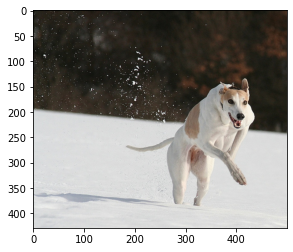

In [33]:
img_path = '/content/flickr8k_dataset/Flicker8k_Dataset/101654506_8eb26cfb60.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('model_25.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [34]:
!pip install gtts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [35]:
query = description
stopwords = ['start','end']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]

In [36]:
description = ' '.join(resultwords)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
for key, desc_list in descriptions.items():
    actual = list()
    predicted = list()
    refrences = list()
		# store actual and predicted
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(description.split())

In [ ]:
# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.125000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge

In [ ]:
r = Rouge()

In [ ]:
r.get_scores(str(predicted), str(actual))

[{'rouge-1': {'r': 0.07692307692307693,
   'p': 0.2857142857142857,
   'f': 0.12121211786960524},
  'rouge-2': {'r': 0.02857142857142857,
   'p': 0.16666666666666666,
   'f': 0.04878048530636538},
  'rouge-l': {'r': 0.07692307692307693,
   'p': 0.2857142857142857,
   'f': 0.12121211786960524}}]

In [45]:
from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
tts = gTTS(description) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)

In [37]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import io
import html
import time
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

In [39]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [40]:
# snippet from camera capture to utilize computer's webcam
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [41]:
# javascript to create live video using webcam video as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

<IPython.core.display.Javascript object>

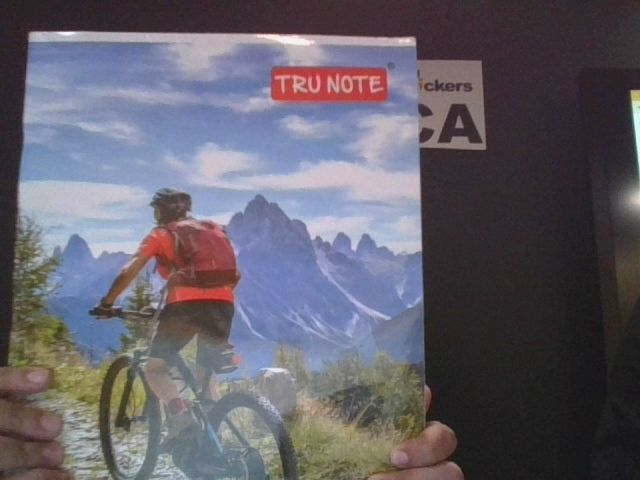

In [66]:
cv2.ocl.setUseOpenCL(False)
image_file=take_photo()
img=cv2.imread(image_file)
cv2_imshow(img)
cv2.imwrite('/content/sample_data/faces/pic.png', img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
if cv2.waitKey(1) & 0xFF == ord('q'):
  cap.release()
  cv2.destroyAllWindows()

1/1 [==============================] - 1s 617ms/step



man in red shirt is walking down the street


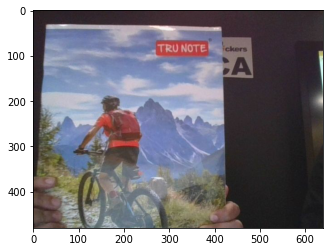

In [67]:

img_path = '/content/photo.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('model_25.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")

query = description
stopwords = ['start','end']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]

description = ' '.join(resultwords)
print(description)
plt.imshow(img)

from gtts import gTTS #Import Google Text to Speech
from IPython.display import Audio #Import Audio method from IPython's Display Class
tts = gTTS(description) #Provide the string to convert to speech
tts.save('1.wav') #save the string converted to speech as a .wav file
sound_file = '1.wav'
Audio(sound_file, autoplay=True)